In [1]:
# libraries 
import os
import re

# libraries for math and database management
import numpy as np
import pandas as pd

# libraries for machine learning
import keras
import sklearn.model_selection
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import class_weight

# liberaries for graphs
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Calculate pharmacophore fingerprint from Schrodinger output

As a first step, we start from the Scrhodinger output files and calculate a linear fngerprint

### Define auxiliary functions, and classes for store fp and ligand data

In [2]:
def alltrips(n):
    """choose of 3 out of n objects, order matters"""
    tt = np.math.factorial(n)/(np.math.factorial(n-3))
    res = [[i,j,k] 
           for i in range(n) 
           for j in range(n) 
           for k in range(n)
           if not i==j and not i==k and not j==k]
    assert len(res)==tt
    return res

def gen_trips(p_types):
    """
    generates all the triples of pharmacophoric points taken from the p_types types
    """
    n = len(p_types)
    res = [ [p_types[i], p_types[j], p_types[k]] 
           for i in range(n) 
           for j in range(n)
           for k in range(n)]
    return res

def get_list(lig_beads, p_type):
    """extracts all triplets of given type from a ligand""" 
    n_beads = len(lig_beads)
    trips = alltrips(n_beads)
    res=[]
    for i,tt in enumerate(trips):
        if all(np.array(lig_beads)[tt]==p_type):
            #print(tt)
            res.append(tt)
    return res


def remap1(types,map1):
    r=[]
    if map1:
        for t in types:
            if t in map1.keys():
                r.append(map1[t])
            else:
                r.append(t)
    else:
        r=types
    return r

def binning(dist, dmin, dmax, n_bins):
    """converts a set of distances into bins for a give choice of the binning"""
    if dist.shape[0]==0:
        return []
    else:
        assert dist.max() <= dmax and dist.min() >= dmin
        return ((n_bins-1)*(dist-dmin)/(dmax-dmin)).astype('int')
    
def block(distances,n_bins):
    """takes a set of distances and maps it onto a block"""
    t = np.zeros(shape=(3,n_bins))
    
    for d in distances:
        for i in range(3):
            t[i,d[i]] += 1./distances.shape[0]
    return np.hstack(t)



In [4]:
## fp class sets the parameters of the FP

class fp(object):

    def __init__(self, typesR, n_bins, dmin=0, dmax=25, remap=None):
        
        types=list(set(remap1(typesR,remap)))
        p_types=gen_trips(types)
        print('types: '+','.join(types))
        
        #n_bins = 10
        dx = (dmax-dmin)/n_bins
        print("bins ->  min:%f, max:%f, n:%d / dx:%f"%(dmin,dmax,n_bins,dx))
        fp_len = len(p_types)*3*n_bins
        print("fingerprint has %d sections"% len(p_types))
        print("fingerptins is %d long"%fp_len)

        self.p_types=p_types
        self.n_bins=n_bins
        self.dmin = dmin
        self.dmax = dmax
        self.fp_len=fp_len
        self.remap=remap
        

        headers=[]
        for p_type in p_types:
            blockname = '/'.join(p_type)
            for dist_name in ['d1','d2','d3']:
                for bi in range(n_bins):
                    headers.append("%s_%s_%d"%(blockname,dist_name,bi))

        self.headers=headers

    def binning(self,dist):
        return binning(
            dist, 
            dmin = self.dmin, 
            dmax = self.dmax, 
            n_bins = self.n_bins)
        
    def block(self, distances):
        return block(distances, self.n_bins)


    
class ligand(object):
    
    def __init__(self, filen=None, beads=None, coords=None, name=None, verbose = False):
        if filen==None:
            self.from_data(beads,coords,verbose)
            self.name=None
        else:
            y = np.genfromtxt(filen,dtype=None)
            beads = [x[1].decode("utf-8")  for x in y]
            coords = np.array([[x[2],x[3],x[4]]  for x in y])
            self.name=filen
            self.from_data(beads,coords,verbose)
            
    def from_data(self,beads,coords,verbose):
        self.beads=beads
        self.coords=coords
        n = len(beads)
        d = np.zeros(shape=(n,n))
        for i in range(n):
            for j in range(i,n):
                d[i,j]=np.sqrt(((coords[i,:]-coords[j,:])**2).sum())
                d[j,i]=d[i,j]
        self.dists=d
        mmin = d[np.triu_indices(n,1)].min()
        mmax = d.max()
        if verbose:
            print("max: %f, min:%f"%(mmax,mmin))
        self.n = n
        self.mmin = mmin
        self.mmax = mmax
        
    def get_dists3(self,ats):
        """
        returns d1,d2,d3 for three points
        """
        return np.array([self.dists[ats[0],ats[1]],
                self.dists[ats[1],ats[2]],
                self.dists[ats[0],ats[2]]])
    
    def get_dists_triplet_types(self,p_types,remap):
        """
        get all the distances for a given triplet type
        """
        ## all the atoms trips that match the given type
        bs = remap1(self.beads,remap)
        trips=get_list(bs,p_types)           
        #return trips
        return np.array([self.get_dists3(t) for t in trips])

    ## loop over all ptypes in a set and return the fingerprint

    def get_fp(self,fp1,verbose=False):
        
        p_types = fp1.p_types
        
        fp = []
        for p_type in p_types:
            get1_tr = self.get_dists_triplet_types(p_type,fp1.remap)
            f =  fp1.binning(get1_tr)
            fp.append(fp1.block(f))
            if verbose:
                print('/'.join(p_type), block(f))
        return np.hstack(fp)


## simple examples

In [ ]:
##define a ligand 
#l1 = ligand(
#    beads=['a','b','b','b'],
#    coords=np.array([[5,5,5],[10,10,10],[20,20,20],[25,25,25]]))
#
#l2 = ligand(filen='ff1',verbose = True)


#how to get the list of atoms matching a given set of types
#lig_beads=['a','a','b','b']
#get_list(lig_beads,['a','b','b'])

# how to get distances for three porints l1.get_dists3([1,2,3])
# how to get triplets matching a given type set l1.get_dists_triplet_types(['a','a','b'])

## the binnded distances corresponding to a given triplet type
#(binning(l1.get_dists_triplet_types(['a','a','b'])))

## the fingerprint block
#fp_b = block(binning(l1.get_dists_triplet_types(['a','a','b'])))
#fp_b

#fp1 = fp(['a','b','c'],10, dmax=35)

## calc fp for ligand l1
#l1.get_fp(fp1);


### Read data from files and create ligand instances

In [5]:

dir1 = 'data/antagonists67Coords/'
dir2 = 'data/agonists412Coords/'

ligs=[]
for dir in [dir1,dir2]:
    for fname in os.listdir(dir):
        ligs.append(ligand(filen=dir+fname))
## collect max, min and types and create fp object

n_lig = len(ligs)

b_type = np.unique(
    [b for l in ligs for b in l.beads ])
b_min= np.min([l.mmin for l in ligs])
b_max= np.max([l.mmax for l in ligs])

print("ligands found: %d"%n_lig )

print("types found:" + ','.join(b_type))
print("max, min distances: %f,%f"% (b_max,b_min))



ligands found: 479
types found:A,D,H,N,P,R
max, min distances: 29.115743,0.075799


### from ligand filename, obtain ligand name, ligand class and ligand number

In [6]:
def getInfo(lig):
    ligandstring = lig.name.split('/')[-1].split(".")[0]
    r = re.match(u'(.+)_(antagonist|agonist)_([0-9]*)$',ligandstring,re.M)
    if r:
        return r.groups() + (ligandstring,)
    else:
        r = re.match(u'(.+)_(antagonist|agonist)',  ligandstring, re.M)
        if r:
            return r.groups() + (0,ligandstring,)
        else:
            raise 
            

ligand_IDs = [getInfo(lig) for lig in ligs]
len(ligand_IDs)
lID = pd.DataFrame({
    'name':[l[0] for l in ligand_IDs],
    'class':[l[1] for l in ligand_IDs],
    'num': [l[2]  for l in ligand_IDs],
    'string': [l[3] for l in ligand_IDs]})


lID.sort_values(['class','name','num']).head()

,name,class,num,string
398,3-HO-PCP,agonist,1,3-HO-PCP_agonist_1
219,3-HO-PCP,agonist,2,3-HO-PCP_agonist_2
370,7-Hydroxymitragynine,agonist,1,7-Hydroxymitragynine_agonist_1
162,7-Hydroxymitragynine,agonist,2,7-Hydroxymitragynine_agonist_2
449,AH-7921,agonist,0,AH-7921_agonist


## calculate fingerprints

In [7]:
## define fp object 
## map N,P -> c A,D -> hb
charged_hb = {'N':'c','P':'c','A':'hb','D':'hb'}
charged_ = {'N':'c','P':'c'}

fp2 = fp(b_type, n_bins= 5, dmin = int(b_min), dmax = 1+int(b_max),remap=charged_)

types: c,D,R,A,H
bins ->  min:0.000000, max:30.000000, n:5 / dx:6.000000
fingerprint has 125 sections
fingerptins is 1875 long


In [8]:
## calculate all fps
all_fps = []
for i,l in enumerate(ligs):
    if i % 10 == 0:
        print("%f done"% (float(i)/len(ligs)))
    all_fps.append(l.get_fp(fp2))

0.000000 done
0.020877 done
0.041754 done
0.062630 done
0.083507 done
0.104384 done
0.125261 done
0.146138 done
0.167015 done
0.187891 done
0.208768 done
0.229645 done
0.250522 done
0.271399 done
0.292276 done
0.313152 done
0.334029 done
0.354906 done
0.375783 done
0.396660 done
0.417537 done
0.438413 done
0.459290 done
0.480167 done
0.501044 done
0.521921 done
0.542797 done
0.563674 done
0.584551 done
0.605428 done
0.626305 done
0.647182 done
0.668058 done
0.688935 done
0.709812 done
0.730689 done
0.751566 done
0.772443 done
0.793319 done
0.814196 done
0.835073 done
0.855950 done
0.876827 done
0.897704 done
0.918580 done
0.939457 done
0.960334 done
0.981211 done


## remove trivial bits

In [9]:
trivials = np.array(all_fps).var(axis=0)==0
print("trivial bits %d"%sum(trivials))
np.array(fp2.headers)[~trivials]

trivial bits 633


array(['c/c/c_d1_0', 'c/c/c_d1_1', 'c/c/c_d2_0', ..., 'H/H/H_d3_0',
       'H/H/H_d3_1', 'H/H/H_d3_2'], 
      dtype='<U10')

In [10]:
fp = pd.DataFrame(np.array(all_fps)[:,~trivials])
fp.columns = np.array(fp2.headers)[~trivials]
fp.head()

,c/c/c_d1_0,c/c/c_d1_1,c/c/c_d2_0,c/c/c_d2_1,c/c/c_d3_0,c/c/c_d3_1,c/c/D_d1_0,c/c/D_d1_1,c/c/D_d1_2,c/c/D_d2_0,...,H/H/A_d3_3,H/H/H_d1_0,H/H/H_d1_1,H/H/H_d1_2,H/H/H_d2_0,H/H/H_d2_1,H/H/H_d2_2,H/H/H_d3_0,H/H/H_d3_1,H/H/H_d3_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [11]:
lID.head()

,name,class,num,string
0,Eptazocine,antagonist,0,Eptazocine_antagonist
1,Nalmefene,antagonist,0,Nalmefene_antagonist
2,Lobeline,antagonist,0,Lobeline_antagonist
3,Diacetylnalorphine,antagonist,1,Diacetylnalorphine_antagonist_1
4,Naltrexone,antagonist,0,Naltrexone_antagonist


In [12]:
data = pd.concat([lID, fp], axis=1, sort=False)

In [13]:
d2 = data.sort_values(['class','name','num'])
d2.index = d2['string']

In [14]:
d2.groupby(['class','name']).size();

### load weights

In [15]:
weights=[]
for file in [
    "data/pharmacophore_scoringPenaltyWeightsAntagonists.csv",
    "data/pharmacophore_scoringPenaltyWeightsAgonists.csv"]:
    
    weights1=pd.read_csv(
        file,
        delimiter=' ',
        header=None, 
        skipinitialspace=True,
        names=["ligand_filename","weight"])
    
    weights.append(weights1)


        
w = pd.concat(weights,axis=0)
l_string = [l.split(".")[0] for l in w['ligand_filename']]
w.index=l_string
w.head()

,ligand_filename,weight
18-Methoxycoronaridine_antagonist,18-Methoxycoronaridine_antagonist.xyz,0.0190
Diacetylnalorphine_antagonist_4,Diacetylnalorphine_antagonist_4.xyz,0.0000
"4-Caffeoyl-1,5-quinide_antagonist","4-Caffeoyl-1,5-quinide_antagonist.xyz",0.0027
"4,7-Dihydroxyflavone_antagonist","4,7-Dihydroxyflavone_antagonist.xyz",0.0117
6beta-Naltrexol_antagonist,6beta-Naltrexol_antagonist.xyz,0.0304


In [16]:
d4 = d2.join(w)

In [17]:
wm = lambda x: np.average(x, weights=np.exp(d4.loc[x.index, "weight"]))
d5 = d4.groupby(['class','name']).agg(wm)

In [18]:
d5

A/A/A_d1_0  A/A/A_d1_1  A/A/A_d1_2  \
class      name                                                          
agonist    3-HO-PCP                   0.000000    0.000000    0.000000   
           7-Hydroxymitragynine       0.622222    0.377778    0.000000   
           AH-7921                    0.000000    0.000000    0.000000   
           Acetyldihydrocodeine       1.000000    0.000000    0.000000   
           Acetylfentanyl             0.000000    0.000000    0.000000   
           Acrylfentanyl              0.000000    0.000000    0.000000   
           Akuammicine                1.000000    0.000000    0.000000   
           Alfentanil                 0.542407    0.457593    0.000000   
           Anileridine                1.000000    0.000000    0.000000   
           Apparicine                 0.000000    0.000000    0.000000   
           BW373U86                   0.369192    0.630808    0.000000   
           Benzhydrocodone            0.964286    0.035714    0.000000   
           Benzylmorphine             1.000000    0.000000    0.000000   
           Bezitramide                0.654653    0.272674    0.072674   
           Biphalin                   0.444001    0.475276    0.080723   
           Buprenorphine              0.821429    0.178571    0.000000   
           Butorphanol                0.473695    0.526305    0.000000   
           Butyrfentanyl              0.000000    0.000000    0.000000   
           Carfentanil                1.000000    0.000000    0.000000   
           Casokefamide               0.583319    0.409701    0.006981   
           Cebranopadol               0.000000    0.000000    0.000000   
           Chlornaltrexamine          0.928918    0.071082    0.000000   
           Chloroxymorphamine         0.834232    0.165768    0.000000   
           Codeine                    1.000000    0.000000    0.000000   
           DADLE                      0.553461    0.387978    0.058561   
           Dermorphin                 0.365078    0.524396    0.105263   
           Desmetramadol              0.833333    0.166667    0.000000   
           Desomorphine               0.297649    0.000000    0.000000   
           Dextromoramide             0.515755    0.484245    0.000000   
           Dextropropoxyphene         1.000000    0.000000    0.000000   
...                                        ...         ...         ...   
antagonist Epicatechin_gallate        0.557895    0.442105    0.000000   
           Eptazocine                 0.000000    0.000000    0.000000   
           Gallocatechol              0.604396    0.395604    0.000000   
           Gemazocine                 0.000000    0.000000    0.000000   
           Hyperoside                 0.577075    0.422925    0.000000   
           Ibogaine                   0.000000    0.000000    0.000000   
           LY-255582                  0.333333    0.666667    0.000000   
           Levallorphan               0.000000    0.000000    0.000000   
           Lobeline                   0.666667    0.333333    0.000000   
           Methylnaltrexone           0.821429    0.178571    0.000000   
           Naldemedine                0.732737    0.267263    0.000000   
           Nalmefene                  0.866667    0.133333    0.000000   
           Nalodeine                  1.000000    0.000000    0.000000   
           Nalorphine                 1.000000    0.000000    0.000000   
           Nalorphine_dinicotinate    0.848485    0.151515    0.000000   
           Naloxazone                 0.846289    0.153711    0.000000   
           Naloxegol                  0.428571    0.484848    0.086580   
           Naloxonazine               0.604396    0.395604    0.000000   
           Naloxone                   0.821429    0.178571    0.000000   
           Naltrexone                 0.928571    0.071429    0.000000   
           Naltrindole                0.866667    0.133333    0.000000   
           Naringenin                 0.

In [19]:
d4[d4['name']=="Diacetylnalorphine"]

,name,class,num,string,c/c/c_d1_0,c/c/c_d1_1,c/c/c_d2_0,c/c/c_d2_1,c/c/c_d3_0,c/c/c_d3_1,...,H/H/H_d1_1,H/H/H_d1_2,H/H/H_d2_0,H/H/H_d2_1,H/H/H_d2_2,H/H/H_d3_0,H/H/H_d3_1,H/H/H_d3_2,ligand_filename,weight
string,,,,,,,,,,,,,,,,,,,,,
Diacetylnalorphine_antagonist_1,Diacetylnalorphine,antagonist,1,Diacetylnalorphine_antagonist_1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Diacetylnalorphine_antagonist_1.xyz,0.3078
Diacetylnalorphine_antagonist_2,Diacetylnalorphine,antagonist,2,Diacetylnalorphine_antagonist_2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Diacetylnalorphine_antagonist_2.xyz,0.3078
Diacetylnalorphine_antagonist_3,Diacetylnalorphine,antagonist,3,Diacetylnalorphine_antagonist_3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Diacetylnalorphine_antagonist_3.xyz,0.5352
Diacetylnalorphine_antagonist_4,Diacetylnalorphine,antagonist,4,Diacetylnalorphine_antagonist_4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Diacetylnalorphine_antagonist_4.xyz,0.0000


In [20]:
regressors_col = [c for c in d5.columns if not (c=='weight' or c=='name')]
d6 = d5.reset_index()
x = np.array(d6[regressors_col],dtype='float64')


encoder = LabelBinarizer()
y = encoder.fit_transform(d6['class'])

In [21]:
d6[100:140]

,class,name,A/A/A_d1_0,A/A/A_d1_1,A/A/A_d1_2,A/A/A_d1_3,A/A/A_d2_0,A/A/A_d2_1,A/A/A_d2_2,A/A/A_d2_3,...,c/c/R_d3_0,c/c/R_d3_1,c/c/R_d3_2,c/c/c_d1_0,c/c/c_d1_1,c/c/c_d2_0,c/c/c_d2_1,c/c/c_d3_0,c/c/c_d3_1,weight
100,agonist,Propiram,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
101,agonist,Racemorphan,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004700
102,agonist,Remifentanil,0.600000,0.400000,0.000000,0.000000,0.600000,0.400000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.398709
103,agonist,SC-17599,0.571429,0.428571,0.000000,0.000000,0.571429,0.428571,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.241421
104,agonist,Sinomenine,0.848751,0.151249,0.000000,0.000000,0.848751,0.151249,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.589398
105,agonist,Sufentanil,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.173683
106,agonist,TRIMU5,0.620076,0.379924,0.000000,0.000000,0.620076,0.379924,0.000000,0.000000,...,0.067351,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.815187
107,agonist,Tapentadol,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
108,agonist,Tetrahydropapaveroline,0.496242,0.503758,0.000000,0.000000,0.496242,0.503758,0.000000,0.000000,...,0.488167,0.085843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.201565
109,agonist,Thebaine,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.294277


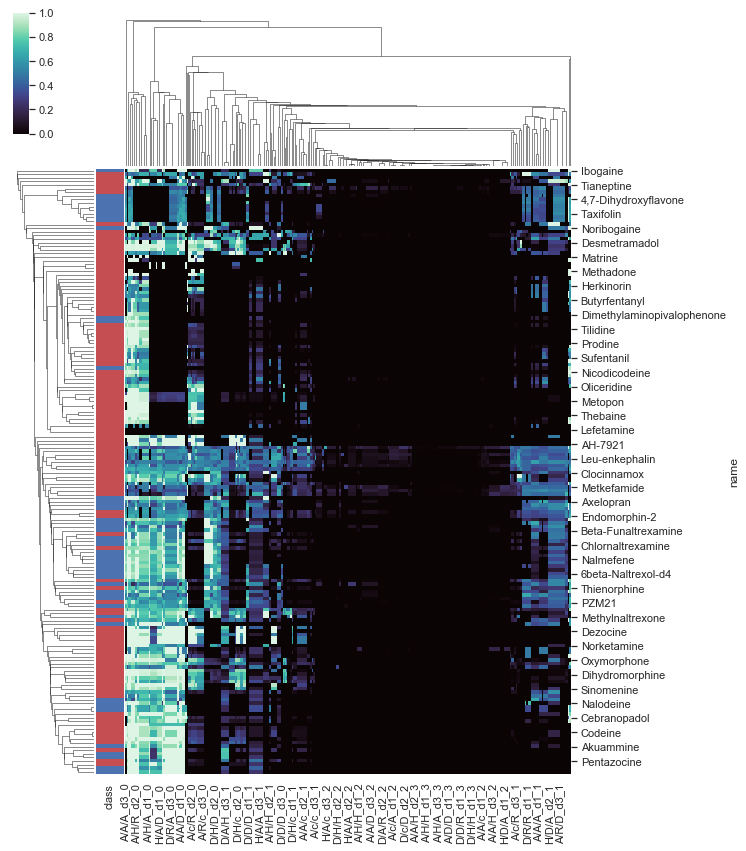

In [147]:
import seaborn as sns; sns.set(color_codes=True)

d6b = d6
d7 = d6b[regressors_col[0:600]]
d7.index = d6b['name']

classes = d6b['class']
lut = dict(zip(classes.unique(), "rbg"))

row_colors = classes.map(lut)
row_colors.index = d6b['name']
g = sns.clustermap(
    d7,
    method="single",
    row_colors=row_colors,
    figsize=(10, 14), 
    cmap="mako")

g.savefig('heatmap.pdf')


In [22]:

x1 = sklearn.preprocessing.scale(np.array(x,dtype='float64'))
#scaler.transform(x)


In [61]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    x1, 
    y, 
    test_size=0.3, 
    random_state=0)

In [68]:
def create_model(x_train):

    model = keras.models.Sequential([
        keras.layers.normalization.BatchNormalization(input_shape=tuple([x_train.shape[1]])),
        keras.layers.core.Dense(32, activation='relu'),
        keras.layers.core.Dense(16, activation='relu'),
        keras.layers.core.Dense(16, activation='relu'),
        keras.layers.core.Dense(1,  activation='sigmoid')
    ])
    
    model.compile(keras.optimizers.Adam(lr=0.001), 
              loss='binary_crossentropy', 
              metrics=["accuracy"])
    
    #print(model.summary())
    return model

# to run single
callback_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    verbose=0, 
    mode='auto')

model = create_model(x_train)
model.fit(x_train, y_train, 
          batch_size=20, 
          epochs=500, 
          validation_data=(x_valid, y_valid), 
          verbose=0, 
          callbacks=[callback_early_stopping])


In [161]:
x_test = x1
y_test = model.predict(x_test)

#print(y_test[:,0].shape)
#print(y[:,0].shape)

In [164]:
#plt.scatter(y[:,0],y_test[:,0])
#plt.scatter(np.arange(len(y_test[:,0])),y_test[:,0],c=y[:,0])
#ax.axhline(y=0.5)



In [133]:

#fig, ax = plt.subplots(figsize=(30,3))
#im = ax.scatter(np.arange(len(y_test[:,0])),y_test[:,0],c=y[:,0])
# We want to show all ticks...
#ax.set_xticks(np.arange(len(y_test[:,0])));
##ax.set_yticks(np.arange(len(row_name)));
## ... and label them with the respective list entries
#ax.set_xticklabels(d6['name']);
##ax.set_yticklabels(row_name);#

## Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
#         rotation_mode="anchor")


In [155]:
preds = pd.DataFrame({
    'name':d6['name'],
    'real_class':d6['class'],
    'pred_class': ["agonist" if y_<0.5 else "antagonist" for y_ in y_test[:,0]],
    'prob_pred': y_test[:,0]
})

preds['misclass'] = -(preds['real_class'] == preds['pred_class'])
preds.groupby(['misclass','real_class', 'pred_class']).size()

misclass  real_class  pred_class
False     agonist     agonist       116
          antagonist  antagonist     46
True      agonist     antagonist      3
          antagonist  agonist         3
dtype: int64

In [156]:
preds[preds['misclass']]

,name,real_class,pred_class,prob_pred,misclass
16,Butorphanol,agonist,antagonist,0.887866,True
39,Embutramide,agonist,antagonist,0.583251,True
74,Mitragynine_pseudoindoxyl,agonist,antagonist,0.729355,True
135,Cyprodime,antagonist,agonist,0.001739,True
136,Diacetylnalorphine,antagonist,agonist,0.005922,True
152,Nalorphine_dinicotinate,antagonist,agonist,0.006000,True


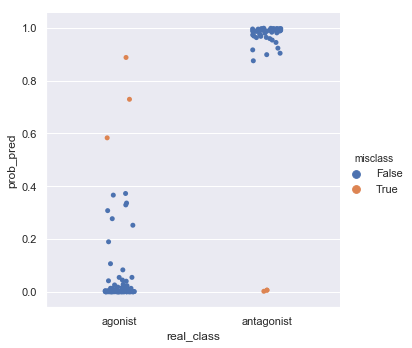

In [168]:
g2 = sns.catplot(x="real_class", y="prob_pred", hue="misclass", data=preds);
g2.savefig('prediction.pdf')